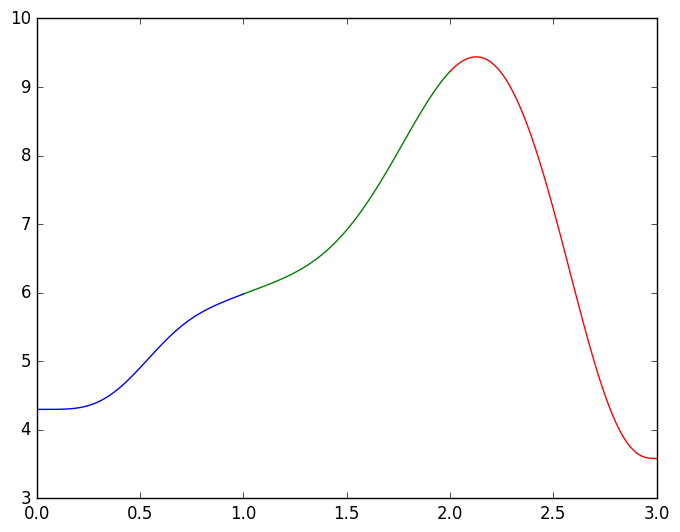

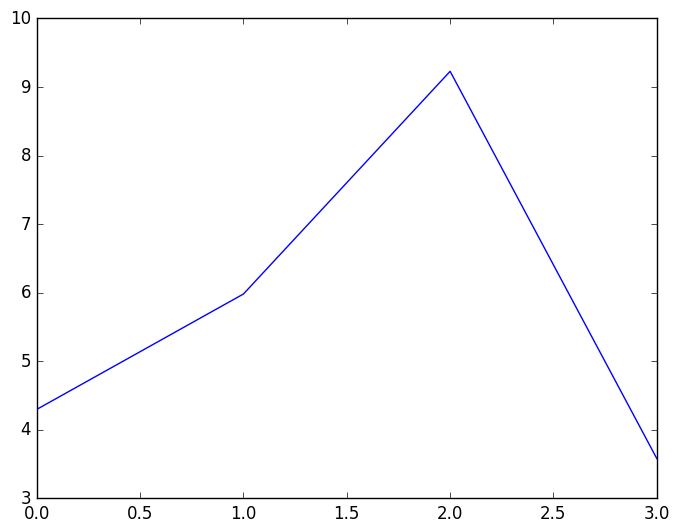

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000002D4C4B38>

Any, Any) in module Main at In[32]:30 overwritten at In[33]:30.


In [33]:
# This code is an attempt work on multi-segment. This is the least tested/thought out of the bunch.

using PyPlot
#Function create_order_vector generates a vector of orders related to the constraints being placed on polynomials
#Assumptions
# degree of the polynomial = numP + 2*numC
# This can be generalized further to determine initial and final continuity however they are ASSUMED equal 
#Inputs
#deg - the number of constraints there will be which is set by the degree of the polynomial to be fit
#numP - the number of points the polynomial is constrained to 
#numC - the number of continuity that you want the polynomial to have with other polynomials
#Output
#order_vec - a column vector of constraint orders starting fixed constraints and then free constraints
#            the order will be ordered points, initial continuity in ascednign order (i.e 1,2,3...), 
#            final continuity (in ascending order)
function create_order_vector(numP, numC)
    #Create vector of zeros of the required size
    order_vec = zeros(Int64, numP);
    
    #Create Set up the initial and final continuities and append to the vector
    order_vec = [order_vec; 1:(numC-1);1:(numC-1)];
    
    return order_vec
    
end


# We need to be less lazy about computing A now. This is a function which returns a row vector corresponding to a constraint of given order at the given time.
function constr_order( order, time, degree)
    if(order==0) 
        row_vec = ones(1,degree); 
        for n=2:degree
            row_vec[1,n] = time^(n-1);
        end
        return row_vec;
    end
    row_vec = zeros(1,degree);
    for n = order:degree-1
        coeff = 1; 
        for k=1:order
            coeff = coeff*(n+1-k)
        end

        row_vec[1,n+1] = coeff * (time^(n-order))
    end
    return row_vec;
end
############################################################################################################
function form_Q(Q_coeffs, t)
    degree = size(Q_coeffs,1)
    Q_mat = zeros(degree,degree)

    for k = 0:degree-1
        if(Q_coeffs[k+1] == 0)
            continue;
        end
        c_k = Q_coeffs[k+1];
        for i=1:degree
        # Form Q
            for l = 1:degree
                if(i >= k && l >= k)                                                   
                    c_tmp = 2*c_k
                    for m = 0:k-1 
                        c_tmp = c_tmp * (i-m)*(l-m);
                    end                                                                
                    Q_mat[i,l] += c_tmp*(t^(i+l-2*k+1))/(i+l-2*k+1)                    
                end
            # Else 0
            end
        end
    end 
    return Q_mat                                                                       
end
######################################Variables to change##################################################
num_points = 4;
points_per_poly = 2; #the number of points that each polynomial will have
num_poly = num_points-1; #number of polynomials to fit
deg_continuity = 5; #the degree to which adjacent polynomials should be continuous
#Create vectors for the initial and final conditions
#                 v, a, j, s
init_Conditions = [0,0,0,0];
#                  v, a
final_Condtions = [0,0]
xvals = rand(num_points)*10;
yvals = rand(num_points)*10;
points = [xvals yvals zeros(num_points,2)];
#figure(42); clf(); scatter(xvals, yvals);

initial_cont = 2;
final_cont = 2;
cont_order = 5; # order of continuity to enforce
vinit = [1,0,0,0]; vfinal =[1,0,0,0];
ainit = [0,0,0,0]; afinal =[0,0,0,0];
times = linspace(0,4,num_points);
period = 1;
num_segs = num_points-1;
#########################################################################################################

#Calculate/Set the degree of each polynomial
degree=points_per_poly+2*(deg_continuity-1); #ASSUMED this for; this does not need to be true necessarily and can be relaxed later


####################Create the A matrices for each set of polynomials#########################
#create the order vectors, can be optimized later
#Organized as Fixed and Free constraints assuming that the degree of continuity is specified initially and free at the end
#ASSUMING that all polynomials have same degree
orders_mat = zeros(Int64, num_poly, degree); #may want to make this a cell array later to deal with polynomials of different order 
#Create a time vector for each polynomial
times_mat = zeros(num_poly, degree);
for looper = 1:(num_poly)      
    orders_mat[looper,:] = create_order_vector(points_per_poly,deg_continuity);
    #ASSUME only two points
    times_mat[looper,:] = [looper-1;looper;(ones(deg_continuity-1)*(looper-1));ones(deg_continuity-1)*looper] * period;
end
####For the first and last polynomials there is a different # of free and fixed to take into account
####v = velocity, a = acceleration, j = jerk, s = snap i= initial, e = end
###order1 = [zeros(Int64,2);   [1;2;3;4];            [1;2;3;4]]; #first poly
###order2 = [zeros(Int64,2);   [1;2;3;4];           [1;2;3;4]]; #middle poly
####      fixed    point     i-v,a,j,s e-v,a  free e- j s
###order3 = [zeros(Int64,2);   1;2;3;4;   1;2;         3;4]; #end poly

####create time indexes too from the time vector Done by hand here
###time1 = [0,1,0,0,0,0,1,1,1,1]*period;
###time2 = [1,2,1,1,1,1,2,2,2,2]*period;
###time3 = [2,3,2,2,2,2,3,3,3,3]*period;


#Create an 3D A matrix to hold the A's for each polynomial
#ASSUMES all polynomials have same degree
A_mat = zeros(degree * num_poly, degree * num_poly);
####Create the actual A matrices now after initializing
###A_1=zeros(degree,degree);
###A_2=zeros(degree,degree);
###A_3=zeros(degree,degree);
for looper = 1:num_poly
    for n=1:degree
        #All constrainst done at once - Can be changed later
        A_mat[n+degree*(looper-1),(1:degree)+degree*(looper-1)] = constr_order(orders_mat[looper,n],times_mat[looper,n],degree);
    end
end
####Create block diagonal A
###println(size(zeros(degree,degree),1))
###println(size(zeros(degree,degree),2))
###A_big = [[A_1 zeros(degree,degree) zeros(degree,degree)];
###        [zeros(degree,degree) A_2 zeros(degree,degree)];
###        [zeros(degree,degree) zeros(degree,degree) A_3]];
A_big = A_mat;

###############################################################################################


####################Create the Q matrix #######################################3
# To optimize for snap, we weight the 5th component:
q_coeffs = zeros(degree);
q_coeffs[3] = 1.0;

####Create small Q
###Q_small = form_Q(q_coeffs, period) 
####Make big q
###Q_mat = [[Q_small zeros(degree,degree) zeros(degree,degree)];
###        [zeros(degree,degree) Q_small zeros(degree,degree)];
###        [zeros(degree,degree) zeros(degree,degree) Q_small]];


#ASSUMES all polys are of the same degree
#Create small Q
Q_small = form_Q(q_coeffs, period)
#Initialize big q
Q_mat = zeros(degree * num_poly, degree * num_poly)
for looper = 1:num_poly
    Q_mat[(1:degree) + degree * (looper - 1),(1:degree) + degree * (looper - 1)] = Q_small;
end

###################################################################

##################Create C matrix (done by hand for now#############################
#should change create larger constraint vector from a smaller vector of uniqure constraints
#it will be a size of degree x unigue constriant matrix, it is large
#Unique constraints as follows, there are 
#   1_01 1_02 1_1
C= [eye(6) zeros(6,20-6);
    #1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
    [zeros(1,10) 1 zeros(1,9)];#7
    [zeros(1,11) 1 zeros(1,8)]; #8
    [zeros(1,12) 1 zeros(1,7)]; #9
    [zeros(1,13) 1 zeros(1,6)];#10
    [zeros(1,1) 1 zeros(1,18)]; #11
    [zeros(1,6) 1 zeros(1,13)];#12
    [zeros(1,10) 1 zeros(1,9)];#13
    [zeros(1,11) 1 zeros(1,8)]; #14
    [zeros(1,12) 1 zeros(1,7)]; #15
    [zeros(1,13) 1 zeros(1,6)]; #16
    [zeros(1,14) 1 zeros(1,5)];#17
    [zeros(1,15) 1 zeros(1,4)]; #18
    [zeros(1,16) 1 zeros(1,3)]; #19
    [zeros(1,17) 1 zeros(1,2)]; #20
    [zeros(1,6) 1 zeros(1,13)]; #21
    [zeros(1,7) 1 zeros(1,12)]; #22
    [zeros(1,14) 1 zeros(1,5)]; #23
    [zeros(1,15) 1 zeros(1,4)]; #24
    [zeros(1,16) 1 zeros(1,3)]; #25
    [zeros(1,17) 1 zeros(1,2)]; #26
    [zeros(1,8) 1 zeros(1,11)]; #27
    [zeros(1,9) 1 zeros(1,10)];#28
    [zeros(1,18) 1 zeros(1,1)]; #29
    [zeros(1,19) 1]];#30]#
#Calculate the number of fixed constraints and free somehow
num_fixed = num_points+length(init_Conditions)+length(final_Condtions);#10; #THIS MAY NEED TO BE REVISED
num_unique = degree+deg_continuity*(num_poly-1);#20; #THIS MAY NEED TO BE REVISED
num_free = num_unique - num_fixed;
#looping ASSUMING all same degree
#ASSUMES THAT d_fixed will have fixed values of poly 1 ,then poly 2, then poly3...
#ASSUMES That with in each poly you have initial values before final
#initialize C
C = zeros(num_poly*degree,num_unique)
counter_index = -1; #A Loop
for looper = 1:(degree*num_poly)
    #Check if we are on the first poly
    if(looper<(degree-deg_continuity+1))
        C[looper,:]=[zeros(1,(looper-1)) 1 zeros(1,num_unique-looper)];
    elseif(looper<(degree))
        counter_index += 1;
        cleaner = num_Fixed+counter_index; #to clean up the typing a bit
        C[looper,:]=[zeros(1,(cleaner)) 1 zeros(1,num_unique-cleaner-1)];
    #Check if it is the last part of the last polynomial  
    elseif(looper>((num_poly)*degree-deg_continuity)
        #Check if it is the last two
        if(looper>((num_poly)*degree-deg_continuity+length(init_Conditions))
            C[looper,:]=[zeros(1,(looper-1)) 1 zeros(1,num_unique-looper+1)];
        else
            C[looper,:]=[zeros(1,(num_points-)) 1 zeros(1,num_unique-looper+1)];
        end
    else
    end
end

########################################################################################33

############################ Compute R = A^-T Q A^-1 ###################################                                                            
# This is bad practice, but easy:                                                      
Ainv = inv(A_big);
R = C'*(Ainv')*(Q_mat*Ainv*C)


#          -     R_fp                                                     *   R_pp^-1
opt_mat = - inv(R[(num_fixed+1):num_unique,(num_fixed+1):num_unique])*R[1:num_fixed,(num_fixed+1):num_unique]'; 
##########################################################################################

###############################Compute optimal unconstrained condidtions#################
#       [xpts[1],xpts[2],vint[1],aint[1],jint[1],sint[1],xpts[3],xpts[4],vend, aend]
d_fixed = [xvals[1],xvals[2],0,0,0,0,xvals[3],xvals[4],0,0];
d_free_opt = opt_mat*d_fixed;
#create big constraint vector again to back out coefficients
d_consolidated=[d_fixed; d_free_opt];
coeffs = Ainv*C*d_consolidated;
########################################################################################3

# Plot the one dimesion vs time.
figure(2);
t = linspace(0,1*period,100);
#Create the vector for poly 1
x =0;
for p=1:degree
    x += coeffs[p]*t.^(p-1);
end
plot(t,x)
t = linspace(1*period,2*period,100);
#Create the vector for poly 2
x =0;
for p=(1:degree)+10
    x += coeffs[p]*t.^(p-11);
end
plot(t,x)
t = linspace(2*period,3*period,100);
#Create the vector poly 3
x =0;
for p=(1:degree)+20
    x += coeffs[p]*t.^(p-21);
end
plot(t,x)
figure(3)
plot([0,1,2,3],xvals)

In [27]:
for g = 1:size(times_mat,1)
    println(times_mat[g,:])
end

[0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0]
[1.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0]
[2.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0]


In [39]:
C = zeros(num_poly*degree,num_unique)
for looper = 1:(degree*num_poly)
    #Check if we are on the first or last polynomial
    if(looper<num_unique)
        C[looper,:]=[zeros(1,(looper-1)) 1 zeros(1,num_unique-looper)]
        println(C[looper,:])
    end
end

[1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[0.0,0.0,0.0,0.0

In [40]:
println(9%3)

0
